<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                               Energy Baseline Prediction Of Office Building
</div>

<div style="background-color: #FAF9F6; padding: 20px; border-radius: 10px; font-family: Calibri, sans-serif;text-align: justify;">

### Introduction

Building Sector represents 39% to 40% of energy consumption and 38% to 36% of the CO2 emission in USA and Europe.Buildings consume a significant portion of energy production; thus, energy conservation measures (ECM) may help to reduce potential increases in energy consumption while lowering carbon emissions in the power sector. ECM is dedicated to monitoring, energy efficiency, and the rehabilitation of inefficient loads. It is important to note that the difference between how much energy a building will consume after ECM (i.e., maintenance and rehabilitation) and how much it would have consumed without it can be defined as energy saving. The previous one can effectively attain from a utility meter, but the latter, known as the “energy baseline” only can be acquired by predictions.A baseline energy model can serve as a point of reference for building operators better to understand their buildings’ energy consumption patterns and behavior. These baseline models may be used to calculate energy and cost savings, diagnose energy system faults, and get physical insight into operation trends
    
### Objectives

The primary objectives are:
    
1. To assess the impact of recent of recent improvements on energy consumption. 
2. Detect Unusual Period of energy consumption.     
3. Develop a Baseline Model for Energy Consumption

These objectives align with the organisation's broader Net Zero Stratergy focused on reducing overall energy consumption.
    

</div>

<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                               Importing Libraries
</div>

In [61]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                              Uploading file
</div>

In [3]:
# Load the Excel File
df = pd.read_excel('dataset_office_consumption.xlsx')

# Display first five rows
df.head()

,Timestamp,total_energy,temp
0,2024-01-27T00:00:00Z,5.098246,3.92
1,2024-01-27T00:30:00Z,5.349938,3.92
2,2024-01-27T01:00:00Z,5.131202,3.92
3,2024-01-27T01:30:00Z,5.521787,3.92
4,2024-01-27T02:00:00Z,5.411232,3.92


<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                              Checking Data Quality
</div>

In [4]:
# Inspecting the datatypes
df.dtypes

Timestamp        object
total_energy    float64
temp            float64
dtype: object

In [5]:
# Identifying any missing values
missing_values = df.isna().sum()
missing_values

Timestamp       0
total_energy    0
temp            0
dtype: int64

In [6]:
# Identifying any duplicate values
duplicate_values = df.duplicated().sum()
duplicate_values

0

In [75]:
# Anomaly Detection using IQR Method
# Calculate the first and third quartiles
Q1 = df['total_energy'].quantile(0.25)
Q3 = df['total_energy'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify anomalies based on IQR bounds
df['Anomalies'] = (df['total_energy'] < lower_bound) | (df['total_energy'] > upper_bound)

# Extract the anomalies
iqr_anomalies = df[df['Anomalies']]

# Count the number of anomalies
num_anomalies = len(iqr_anomalies)

# Display the results
print(f"Number of Anomalies Detected: {num_anomalies}")

Number of Anomalies Detected: 654


<div style="background-color: #FAF9F6; padding: 20px; border-radius: 10px; font-family: Calibri, sans-serif;text-align: justify;">

### Question 1 :Are there any data quality issues within the dataset?

1. There were no missing values.
2. There were no duplicate entries in the dataset.
3. Anomalies were detected using the Interquartile Range identifying 654 outliers representing periods of unsual energy consumption that could distort overall consumption pattern.

</div>

<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                              Feature Engineering
</div>

In [76]:
# Extracting Time features
df['datetime'] = pd.to_datetime(df['Timestamp'], errors = 'coerce')
df['Date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day_of_week

# Lag features
df['energy_lag_1'] = df['total_energy'].shift(1)
df['energy_lag_2'] = df['total_energy'].shift(2)

# Base temperature for degree day calculations
base_temp = 18
mean_temp = df['temp'].mean()

# Calculate Heating Degree Days (HDD)
df['HDD'] = df['temp'].apply(lambda temp: max(0, base_temp - mean_temp))

# Calculate Cooling Degree Days (CDD)
df['CDD'] = df['temp'].apply(lambda temp: max(0, mean_temp - base_temp))

# Weekend Indicator
df['Is_Weekend'] = df['Day'].apply(lambda x:1 if x >= 5 else 0)

# Aggregating energy consumption by hour
hourly_consumption = df.groupby('hour')['total_energy'].mean().reset_index()
busiest_hour = hourly_consumption.loc[hourly_consumption['total_energy'].idxmax(), 'hour']

# Create a binary feature indicating if the time is during the busiest hour
df['Is_Busiest_Time'] = np.where(df['hour'] == busiest_hour, 1, 0)

# Fill NaN values introduced by lag features
df[['energy_lag_1','energy_lag_2']] = df[['energy_lag_1','energy_lag_2']].fillna(0)

# Display first five rows
df.head()

,Timestamp,total_energy,temp,IQR_Anomaly,datetime,Date,hour,Year,Month,Day,energy_lag_1,energy_lag_2,HDD,CDD,Is_Weekend,Is_Busiest_Time,Anomalies
0,2024-01-27T00:00:00Z,5.098246,3.92,False,2024-01-27 00:00:00+00:00,2024-01-27,0,2024,1,5,0.000000,0.000000,7.675169,0,1,0,False
1,2024-01-27T00:30:00Z,5.349938,3.92,False,2024-01-27 00:30:00+00:00,2024-01-27,0,2024,1,5,5.098246,0.000000,7.675169,0,1,0,False
2,2024-01-27T01:00:00Z,5.131202,3.92,False,2024-01-27 01:00:00+00:00,2024-01-27,1,2024,1,5,5.349938,5.098246,7.675169,0,1,0,False
3,2024-01-27T01:30:00Z,5.521787,3.92,False,2024-01-27 01:30:00+00:00,2024-01-27,1,2024,1,5,5.131202,5.349938,7.675169,0,1,0,False
4,2024-01-27T02:00:00Z,5.411232,3.92,False,2024-01-27 02:00:00+00:00,2024-01-27,2,2024,1,5,5.521787,5.131202,7.675169,0,1,0,False


<div style="background-color: #FAF9F6; padding: 20px; border-radius: 10px; font-family: Calibri, sans-serif;text-align: justify;">

### Feature Explanation

1. Time Features : For extracting the features such as time, hour, date, month, year, and day.
2. HDD (Heating Degree Days) : Measures the demand for heating. It is calculates as difference between the base temperature and the mean temperature when the actual temperature is below the base. Higher values means higher heating needs, impacting energy consumption.
3. CDD (Cooling Degree Days): Measures the demand for cooling. It is calculates as difference between the mean temperature and the base temperature when the actual temperature is above the base. Higher values indicates greater cooling needs.
4. Is_Weekend: A binary feature indicating whether the day is a weekend.
5. Is_Busiest_Time: The binary features indicates 1 during the v=busiest hours and 0 for the rest.
6. energy_lag_1 : Represents the total energy consumption from previous time step. Helps in understanding consumnption trends and autocorrelaton.
7. energy_lag_2: Represents energy consumption two steps back.
</div>

<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                              Pre Baseline Analysis
</div>

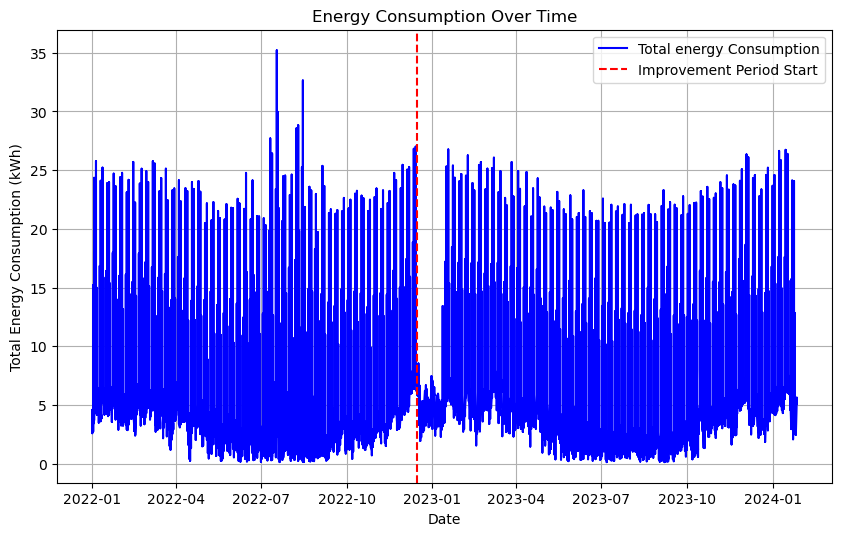

Average Before Improvements: 7.249967181958057 kWh
Average After Improvements: 7.045744685739739 kWh
Reduction in Consumption: 2.82%


In [81]:
# Energy Consumption over timne to visualize changes
plt.figure(figsize = (10,6),dpi = 100)
plt.plot(df['Date'],df['total_energy'], color='blue',
        label = 'Total energy Consumption')
plt.axvline(pd.to_datetime("2022-12-15"), color='red', linestyle='--',
            label='Improvement Period Start')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Splitting data into periods before and after improvements
before_improvement = df[df['datetime'] < str("2022-12-15")]
after_improvement = df[df['datetime'] > str("2022-12-15")]

# Calculating average energy consumption
avg_before = before_improvement['total_energy'].mean()
avg_after = after_improvement['total_energy'].mean()

print(f"Average Before Improvements: {avg_before} kWh")
print(f"Average After Improvements: {avg_after} kWh")
print(f"Reduction in Consumption: {((avg_before - avg_after) / avg_before) * 100:.2f}%")

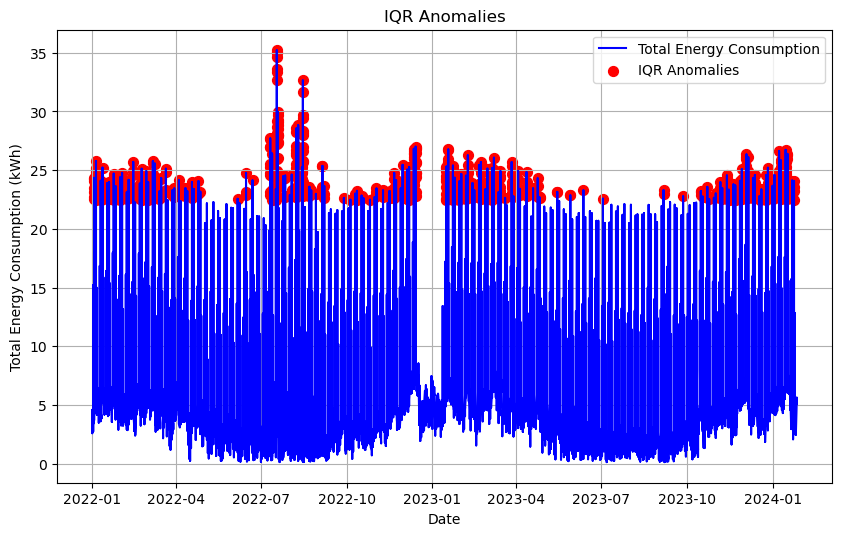

In [90]:
# Plotting the Anomalies detected by IQR method
plt.figure(figsize=(10, 6),dpi = 100)
plt.plot(df['Date'], df['total_energy'], color='blue',
         label='Total Energy Consumption')
plt.scatter(iqr_anomalies['Date'], iqr_anomalies['total_energy'], color='red',
             label='IQR Anomalies', s=50)
plt.title('IQR Anomalies')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
# Removing the outlier from data
df = df[(df['total_energy'] >= lower_bound) & (df['total_energy'] <= upper_bound)]

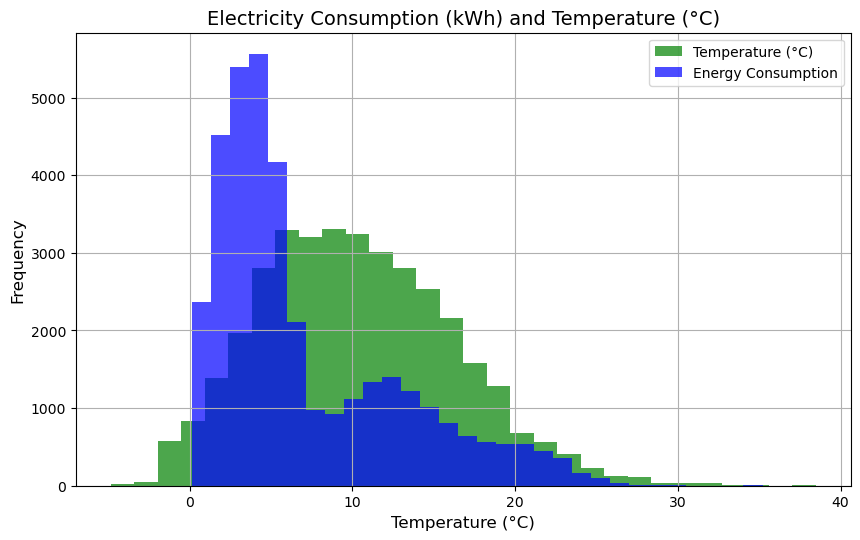

In [89]:
# Histogram to compare Electricity Consumption and temperature
plt.figure(figsize=(10,6),dpi = 100)
plt.hist(df['temp'], bins=30, color='green', alpha=0.7,
         label='Temperature (°C)')
plt.hist(df['total_energy'], bins=30, color='blue', alpha=0.7,
         label='Energy Consumption')
plt.title('Electricity Consumption (kWh) and Temperature (°C)', fontsize=14)
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


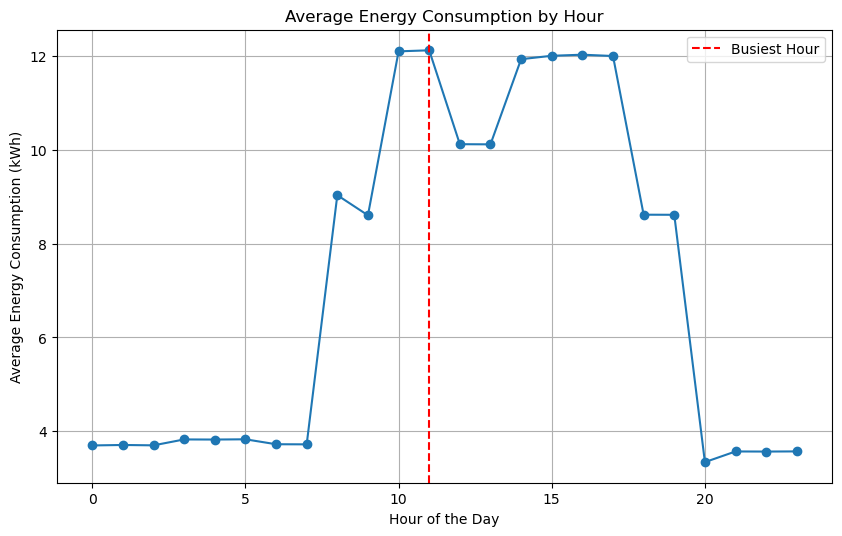

The busiest hour of the day is: 11am


In [83]:
# Plotting the average energy consumption by hour to visualize the busiest time
plt.figure(figsize=(10, 6),dpi = 100)
plt.plot(hourly_consumption['hour'], hourly_consumption['total_energy'], marker='o')
plt.axvline(busiest_hour, color='red', linestyle='--', label='Busiest Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (kWh)')
plt.title('Average Energy Consumption by Hour')
plt.grid(True)
plt.legend()
plt.show()

print(f"The busiest hour of the day is: {busiest_hour}am")

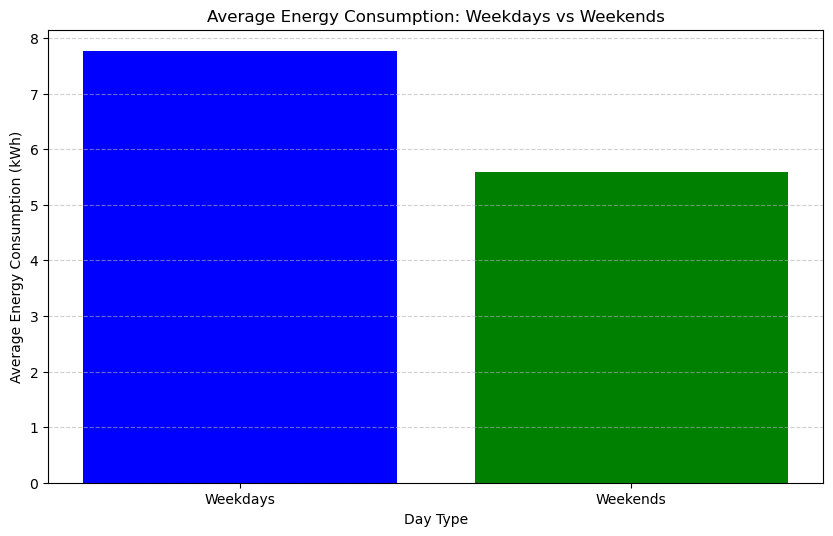

In [99]:
# Aggregate energy consumption by weekdays and weekends to get average values
weekend_weekday_consumption = df.groupby('Is_Weekend')['total_energy'].mean().reset_index()

# Map values for more readable labels for plotting
weekend_weekday_consumption['Day_Type'] = weekend_weekday_consumption['Is_Weekend'].map({0: 'Weekdays', 1: 'Weekends'})

# Plotting the energy consumption for weekdays vs weekends with customized x-axis labels
plt.figure(figsize=(10, 6), dpi=100)
plt.bar(weekend_weekday_consumption['Day_Type'], weekend_weekday_consumption['total_energy'], color=['blue', 'green'])
plt.title('Average Energy Consumption: Weekdays vs Weekends')
plt.xlabel('Day Type')
plt.ylabel('Average Energy Consumption (kWh)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(['Weekdays', 'Weekends'])  
plt.show()

<div style="background-color: #FAF9F6; padding: 20px; border-radius: 10px; font-family: Calibri , sans-serif;text-align: justify;">

### Question 2 :Does the dataset provided show evidence of an improvement done to reduce the energy consumption? 

Based on the analysis, it is evident that the Energy Conversation Measure (ECM) implemented around 15 December, 2022, led to reduction in energy consumption.The average consumption before improvements was approximately 7.25 kWh and after improvements was 7.05 kWh showcasing a reduction of 2.82% demonstrating that the implemented changes are contributing to energy savings.

</div>

<div style="background-color: #FAF9F6; padding: 20px; border-radius: 10px; font-family: Calibri, sans-serif;text-align: justify;">

### Question 3 :What is the site's energy consumption behaviour?

Summary of the site's energy consumption behavious:
    
1. Energy consumption is strongly influenced by temperature variations. As shown in the histogram, higher energy consumption occurs when temperatures are lower, indicating significant heating demand during colder periods.
2. Energy consumption starts increasing from early morning, remains high during typical office hours, and drops towards the evening, reflecting typical office behavior. The site's busiest hour accours around 11 am.
3.Energy consumption is noticeably higher on weekdays compared to weekends. This aligns with expected office behavior.
4.There is a clear correlation between energy usage and specific times of the day, particularly during operational hours.
    
To conclude, The site's energy consumption is driven by operational patterns typical of an office environment, with significant impacts from temperature changes, daily working hours, and reduced activity on weekends.

</div>

<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                              Feature Selection
</div>

In [105]:
# Create features and target variables
X = df[['temp','Year', 'Month', 'Day', 'HDD', 'CDD', 'Is_Weekend', 'energy_lag_1',
        'energy_lag_2','Is_Busiest_Time']]
y = df['total_energy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
# Tain Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Feature importance
importance = model.feature_importances_
features = X.columns

# Create a DataFrame to display the importance of each feature
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

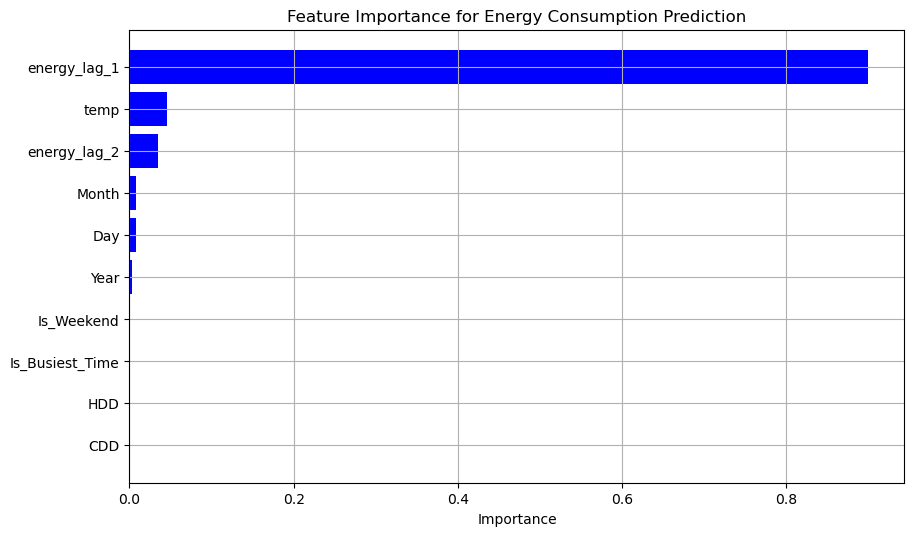

           Feature  Importance
7     energy_lag_1    0.898845
0             temp    0.045215
8     energy_lag_2    0.034721
2            Month    0.008166
3              Day    0.008146
1             Year    0.003279
6       Is_Weekend    0.000892
9  Is_Busiest_Time    0.000736
4              HDD    0.000000
5              CDD    0.000000


In [107]:
# Plotting the feature importance
plt.figure(figsize=(10, 6),dpi = 100)
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], 
         color='blue')
plt.xlabel('Importance')
plt.title('Feature Importance for Energy Consumption Prediction')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# Display the feature importance table
print(feature_importance_df)

<div style="background-color:#ADD8E6;padding: 20px; border-radius: 10px;text-align: center">

#                                              Energy Baseline Model
</div>

In [108]:
# Create features and target variables
features = ['temp', 'Year','Month', 'Day', 'energy_lag_1', 'energy_lag_2', 
            'HDD', 'CDD', 'Is_Busiest_Time']
target = 'total_energy'

# Split the data into training and testing sets
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [109]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:
# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Adding K-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Performing cross-validation 
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='r2')

# Fit the model
model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Results
print(f'Cross-Validation R-squared Scores: {cv_scores}')
print(f'Average R-squared from Cross-Validation: {np.mean(cv_scores):.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'R-squared on Test Set: {r2:.4f}')

Cross-Validation R-squared Scores: [0.87586652 0.87466804 0.87607177 0.87417264 0.87960889]
Average R-squared from Cross-Validation: 0.8761
Root Mean Squared Error: 1.8570
Mean Absolute Error: 0.9137
R-squared on Test Set: 0.8817


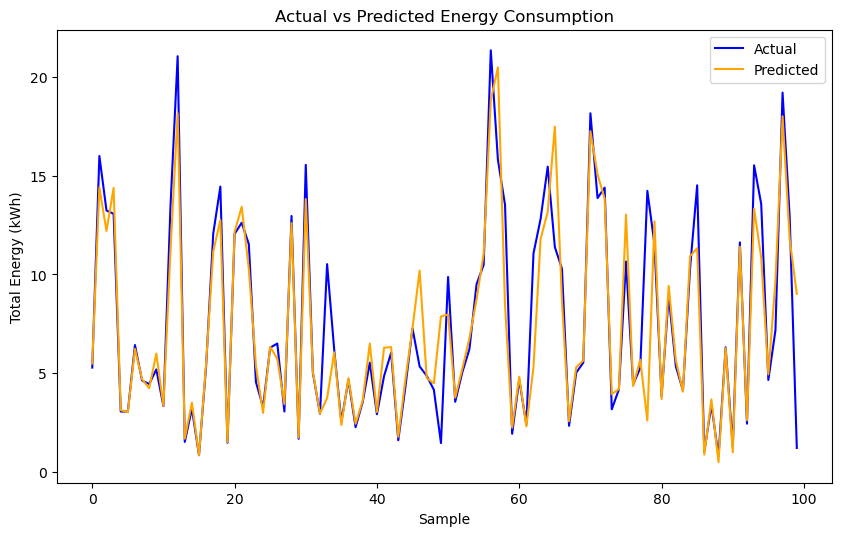

In [103]:
# Plot the predicted vs actual energy consumption
plt.figure(figsize=(10, 6),dpi = 100)
plt.plot(y_test.values[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='orange')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Sample')
plt.ylabel('Total Energy (kWh)')
plt.legend()
plt.show()

In [110]:
# Define the improvement date to separate pre- and post-ECM periods
improvement_date = '2022-12-15'
pre_ecm = df[df['datetime'] < improvement_date]
post_ecm = df[df['datetime'] >= improvement_date].copy()

# Create features and target variables
features = ['temp', 'Year', 'Month', 'Day', 'energy_lag_1', 'energy_lag_2', 'HDD', 'CDD', 'Is_Busiest_Time']
target = 'total_energy'

# Prepare training data using pre-ECM period
X_pre = pre_ecm[features]
y_pre = pre_ecm[target]

# Standardize features
scaler = StandardScaler()
X_pre_scaled = scaler.fit_transform(X_pre)

# Train the baseline model using pre-ECM data
baseline_model = RandomForestRegressor(n_estimators=100, random_state=42)
baseline_model.fit(X_pre_scaled, y_pre)

# Prepare the post-ECM data
X_post = post_ecm[features]
X_post_scaled = scaler.transform(X_post)

# Predict the baseline consumption for the post-ECM period
baseline_predictions = baseline_model.predict(X_post_scaled)
post_ecm['Baseline_Consumption'] = baseline_predictions

# Calculate savings
post_ecm['Savings'] = post_ecm['Baseline_Consumption'] - post_ecm['total_energy']

In [111]:
# Calculate the total energy savings post-ECM
total_savings = post_ecm['Savings'].sum()

# Calculate the total baseline consumption for the post-ECM period
total_baseline_consumption = post_ecm['Baseline_Consumption'].sum()

# Calculate the percentage savings relative to the baseline consumption
percentage_savings = (total_savings / total_baseline_consumption) * 100

# Print the results
print(f"Total Energy Savings Post-ECM: {total_savings:.2f} kWh")
print(f"Percentage Savings Relative to Baseline: {percentage_savings:.2f}%")

Total Energy Savings Post-ECM: 2195.66 kWh
Percentage Savings Relative to Baseline: 1.65%


<div style="background-color: #FAF9F6; padding: 20px; border-radius: 10px; font-family: Calibri, sans-serif;text-align: justify;">

### Question 4 :Can you detect the baseline energy consumption of the site? 

Yes, the baseline energy consumption of the site can be effectively detected using the Random Forest model developed in the analysis.
    
1. A Random Forest Regressor was trained using pre-ECM (pre-improvement) data to model the site’s expected energy consumption under normal conditions before any energy-saving measures were implemented.It depicts the relationship between total energy and other features.
2. The trained model was used to predict the expected (baseline) energy consumption for the period after the ECMs were implemented (post-ECM).
3. By comparing the predicted baseline consumption with the actual consumption post-ECM, the total energy savings were quantified as 2195.66 kWh, which translates to a 1.65% reduction in energy consumption relative to the baseline.
4. The model’s performance metrics (RMSE: 1.85 kWh, MAE: 0.91 kWh, R²: 0.88) indicate that it reliably predicts energy consumption patterns

</div>